In [1]:
import sys
sys.path.insert(0, '../backend')

In [2]:
import pybnb
import numpy as np
import generalized_dtw

In [3]:
x = np.random.rand(5).tolist()
y = np.random.rand(7).tolist()

# Branch-and-Bound

In [8]:
class Lattice(pybnb.Problem):
    
    """ The solver in pybnb keeps track of the best solution seen so far for you, 
        and will prune the search space by not calling the branch() method when it 
        encounters a node whose bound() is worse than the best objective() seen so far.
    """

    def __init__(self, x, y):
        self.x = tuple(x)
        self.m = len(self.x)
        self.y = tuple(y)
        self.n = len(self.y)
        assert self.m > 0
        assert self.n > 0

#         self.values_memoization = {}
        self.path = [(0,0)]
        self.evaluation = [] # keep track of the history of parent function evaluations

    def align(self, path):
        """align x and y according to the path"""
        x_reparam = [self.x[k] for k in [i for i,j in path]]
        y_reparam = [self.y[k] for k in [j for i,j in path]]
        return x_reparam, y_reparam
    
    def distance(self, path):
        x, y = self.align(path)
        return np.sqrt(np.sum([(xx-yy)**2 for xx,yy in zip(x,y)]))
        
    def sense(self):
        return pybnb.minimize

    def objective(self):
        """ The search space is not all paths in the tree, but only complete paths, 
            i.e. paths terminating at (m,n), the very last node for all branches.
            by returning self.distance(self.path) only when self.path is a complete 
            path will ensure to optimise over the right search space (instead of 
            optimising over all possible partial paths on the tree).
        """
        
        if self.path[-1] == (self.m-1,self.n-1):
            val = self.distance(self.path)
        else:
            val = self.infeasible_objective()

        # TODO: do we need to keep track of values calculated along each path?
        assert len(self.evaluation) in (len(self.path), len(self.path)-1)
        if len(self.evaluation) == len(self.path)-1:
            self.evaluation.append(val)

        return val

    def bound(self):
        """ This function is evaluate at a partial path and needs to be a lower bound on any complete 
            path originating from it, so it can decide if the search needs to continue 
            along a partial path based on the best known objective.
        """        
#         return self.unbounded_objective()
        return self.distance(self.path)

    def save_state(self, node):
        node.state = (list(self.path), list(self.evaluation))

    def load_state(self, node):
        (self.path, self.evaluation) = node.state

    def branch(self):
        
        i,j = self.path[-1]
        
        if (i==self.m-1) and (j<self.n-1):
            child = pybnb.Node()
            child.state = (self.path + [(i,j+1)], list(self.evaluation))
            yield child
        
        elif (i<self.m-1) and (j==self.n-1):
            child = pybnb.Node()
            child.state = (self.path + [(i+1,j)], list(self.evaluation))
            yield child
        
        elif (i<self.m-1) and (j<self.n-1):
            child = pybnb.Node()
            child.state = (self.path + [(i+1,j)], list(self.evaluation))
            yield child
        
            child = pybnb.Node()
            child.state = (self.path + [(i,j+1)], list(self.evaluation))
            yield child
        
            child = pybnb.Node()
            child.state = (self.path + [(i+1,j+1)], list(self.evaluation))
            yield child
            
#     def notify_new_best_node(self, node, current=True):
#         print('we found a new best', node)

In [9]:
problem = Lattice(x, y)

In [10]:
solver  = pybnb.Solver(comm=None)

In [11]:
results = solver.solve(problem,
#                        log=None,
#                        queue_strategy='breadth',
                       queue_strategy='depth'
                      )


Using non-default solver options:
 - queue_strategy: depth (default: bound)

Starting branch & bound solve:
 - dispatcher pid: 9788 (DESKTOP-0T8DJ4J)
 - worker processes: 1
--------------------------------------------------------------------------------------------------------------------------
         Nodes        |                      Objective Bounds                       |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap         Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         1  |            inf            -inf         inf%             inf |      0.0       0.00     0.00%      0
         1         3  |            inf       0.4015123         inf%             inf |      0.0     285.72     0.00%      0
*       11         8  |       1.077001       0.4015123   62.719403%    0.6754884588 |      0.0    1192.76     0.00%      0
*       53         6  |       1.076267       0.4015123   62.693996%    0.6747549831 |      0.

In [12]:
results.best_node.objective

0.725306478329863

In [13]:
print(results.best_node.state)

([(0, 0), (0, 1), (1, 2), (1, 3), (1, 4), (2, 5), (3, 5), (4, 6)], [inf, inf, inf, inf, inf, inf, inf, 0.725306478329863])


# Test with other code for DTW

In [14]:
# Euclidean
d = lambda a, b: (a-b)**2
f_d = lambda DD, a, b: np.sqrt(DD**2 + d(a, b))
final_operator = lambda x: np.sqrt(x)

In [15]:
W = generalized_dtw.Warp(x, y, d, f_d, final_operator)

In [16]:
W.warping_path[:-1]

[[4, 6], [3, 5], [2, 5], [1, 4], [1, 3], [1, 2], [0, 1]]

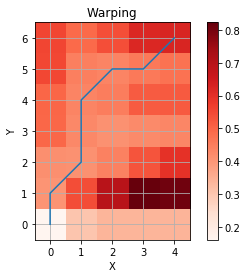

In [17]:
W.plot_lattice()

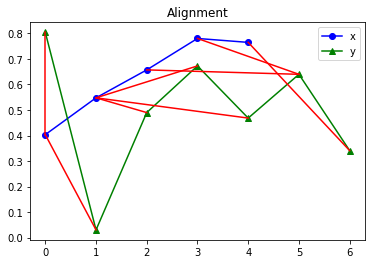

In [18]:
W.plot_alignment()

In [19]:
W.cost

0.7253064783298628